3.609003782272339


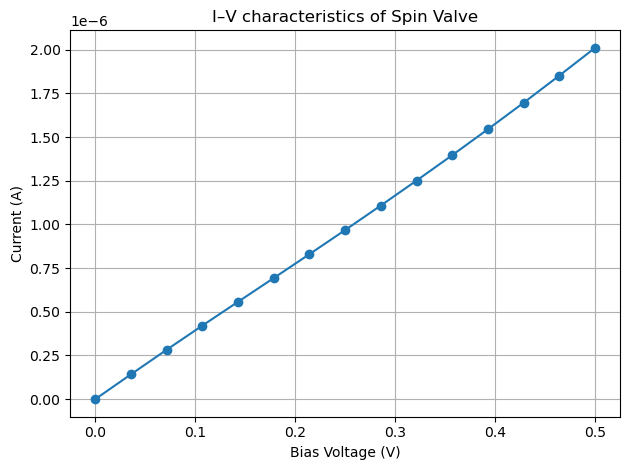

In [1]:
#Include only parrallel and anit-parrallel case

import numpy as np
import matplotlib.pyplot as plt
import time

'''Declearning Constand and Inputs =================='''
t1= time.time()
# Constants (all MKS, except energy which is in eV)
hbar = 1.06e-34
q = 1.6e-19

#Effective mass in lattice for insulator and ferromagnet
m = 0.18* 9.1e-31
mfm = 0.8*9.1e-31
IE = (q*q) / (2 * np.pi * hbar)
Ef = 2.25
kT = 0.025

#Band Energy of insulator with respect to ferromagnet
Ecc = 3.02

# Inpupt a =size of lattice
a = 0.25e-10

#t0, tm are values of t in channel and magnet repectivily (NOTE:for now we have asumme energy Ec is same in both)
t0 = (hbar**2) / (2 * m * (a**2) * q) 
tm = (hbar**2) / (2 * mfm * (a**2) * q)

#Represent 'Extra energy or hamaltonian' due to ferromagnet
alpha = 2.15
beta = 0
alpha1 =2.15
beta1 = 0

#Lattic point in Source, channel and Drain
NS = 2
NC = 38
ND = 2
Np = NS + NC + ND


#Magnetization can be parrallel or anti parrallel only

'''Constructing Hamaltonian =========================-'''

diag0 = np.zeros(2*Np)

for i in range((NS-1)):
    #For parrallel magnetization
    diag0[2*i] = 2*tm+alpha
    diag0[2*i+1] = 2*tm+beta
    diag0[2*(Np-1-i)] = 2*tm+alpha1
    diag0[2*(Np-i)-1] = 2*tm+beta1

for i in range((NC)):
    diag0[2*(NS+i)] = 2*t0 +Ecc
    diag0[2*(NS+i)+1] = 2*t0 +Ecc

#Terms to account for variable 
diag0[2*NS-2] = tm+t0+alpha/2 +Ecc/2
diag0[2*NS-1] = tm+t0+beta/2 +Ecc/2
diag0[2*(Np-NS)] = tm+t0+alpha1/2 +Ecc/2
diag0[2*(Np-NS)+1] = tm+t0+beta1/2 +Ecc/2



#Off diagonal terms
diag2 = np.zeros(2*(Np-1))
diag2[:2*(NS-1)] = tm
diag2[2*(NS+NC):] = tm
diag2[2*(NS-1):2*(NS+NC)] = t0


T = (np.diag(diag0) - (np.diag(diag2, k=2)) - (np.diag(diag2, k=-2)))

#No barrier
UB = np.zeros(2*Np)

T = T + np.diag(UB)  

'''Applying Basis Votage    ================================='''    

# Bias
V_range = np.linspace(0, 0.5, 15) # Range of bias voltages to calculate
I_array = [] # Array to store the currents for each bias voltage

j =0
for V in V_range:
    mu1 = Ef + (V/2)
    mu2 = Ef - (V/2)
    U1 = V * np.concatenate((0.5 * np.ones(2*NS), np.linspace(0.5, -0.5, 2*NC), -0.5 * np.ones(2*ND)))
    for i in range(NC):
        U1[2*(NS+i)+1]= U1[2*(NS+i)]

    '''Applying Green method at different Energy ============='''
    # Energy grid for Green's function method
    NE = 201
    E = np.linspace(mu2-15*kT, mu1+15*kT, NE)
    zplus = 1j * 1e-12
    dE = E[1] - E[0]
    f1 = 1 / (1 + np.exp((E - mu1) / kT))
    f2 = 1 / (1 + np.exp((E - mu2) / kT))

    # Transmission
    I = 0  # Current
    TM = np.zeros(NE)

    for k in range(NE):
        sig1 = np.zeros((2*Np, 2*Np), dtype=complex)
        sig2 = np.zeros((2*Np, 2*Np), dtype=complex)
        sig3 = np.zeros((2*Np, 2*Np), dtype=complex)
        #For contact 1
        ck_up = 1 - ((E[k] + zplus - U1[0] - UB[0]-alpha) / (2 * tm))
        ka_up = np.arccos(ck_up)
        sig1[0, 0] = -tm * np.exp(1j*ka_up)
        ck_down = 1 - ((E[k] + zplus - U1[0] - UB[0]-beta) / (2 * tm))
        ka_down = np.arccos(ck_down)
        sig1[1, 1] = -tm * np.exp(1j*ka_down)
        gam1 = 1j * (sig1 - np.conj(sig1.T))
        
        #For contact 2
        ck_up = 1 - ((E[k] + zplus - U1[2*Np-2] - UB[2*Np-2]-alpha1) / (2 * tm))
        ka_up = np.arccos(ck_up)
        sig2[2*Np-2,2*Np-2] = -tm * np.exp(1j*ka_up)
        ck_down = 1 - ((E[k] + zplus - U1[2*Np-1] - UB[2*Np-1]-beta1) / (2 * tm))
        ka_down = np.arccos(ck_down)
        sig2[2*Np-1,2*Np-1] = -tm * np.exp(1j*ka_down)
        gam2 = 1j * (sig2 - np.conj(sig2.T))
        
        G = ((E[k] + zplus) * np.eye(2*Np)) - T - np.diag(U1) - sig1 - sig2 - sig3
        TM[k] = np.real(np.trace(np.dot(np.dot(gam1, np.linalg.inv(G)), np.dot(gam2,np.conj((np.linalg.inv(G)).T)))))
        I = I + (dE * IE * TM[k] * (f1[k] - f2[k]))
    I_array.append(I)
        

t2 = time.time()


print(t2-t1)
# Plot transmission vs energy
plt.plot(V_range, I_array, marker='o')
plt.xlabel("Bias Voltage (V)")
plt.ylabel("Current (A)")
plt.title("I–V characteristics of Spin Valve")
plt.grid(True)
plt.tight_layout()
plt.show()

